## Joanna Piega 
# Praca domowa 6


# Budowa modelu

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib
import seaborn as sns
matplotlib.style.use('ggplot')
data = pd.read_stata("data.dta")

Zmienne, na podstawie których zostanie zbudowany model to:
    * q26 - odpowiada za informację czy partnerzy byli studentami jednej uczelni
    * ppeducat - odpowiada za poziom wykształcenia
    * q24_met_online - czy partnerzy poznali się online
    * how_long_relationship - jak długo trwa związek
    * age_difference - jaka jest różnica wieku między partnerami

## Przekształcenie danych na dane numeryczne

In [10]:
data = data[["s1","age_difference","q26","ppeducat","q24_met_online","how_long_relationship","q16"]]
data = data[data.isnull().sum(axis = 1) == 0]
data.q24_met_online = pd.Categorical(data.q24_met_online).codes
data.ppeducat = pd.Categorical(data.ppeducat).codes
data.q26 = pd.Categorical(data.q26).codes
data.s1 = pd.Categorical(data.s1).codes

## Podział danych na zbiór treningowy i testowy

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data.iloc[:,1:6],data.s1, test_size = 0.10, random_state = 0)

## Stworzenie modelu predykcyjnego - XGBoost

In [12]:
from xgboost import XGBClassifier
model = XGBClassifier(max_depth=10)
model.fit(X_train,Y_train)
y_pred = model.predict(X_test)

## Ocena jakości zbudowanego modelu

Accuracy

In [13]:
from sklearn.metrics import accuracy_score
round(accuracy_score(Y_test, [round(i) for i in y_pred]),2)*100

75.0

# Wyznacz reszty dla tego modelu na zbiorze danych uczących.



In [14]:
predictions = model.predict_proba(X_test)[:,1]
residuals = predictions - (Y_test) 

## Narysuj wykres kropkowy pokazujący zależność pomiędzy resztą (y - hat y) a wynikiem modelu (hat y). Dodaj krzywą lokalnego trendu (np. loess lub gam) i sprawdź czy różni się od funkcji stale równej zero. Przykładowy wykres diagnostyczny (lewy górny)



In [15]:
res_plot = pd.DataFrame(np.transpose(np.array([predictions,residuals])), columns=["pred","res"])

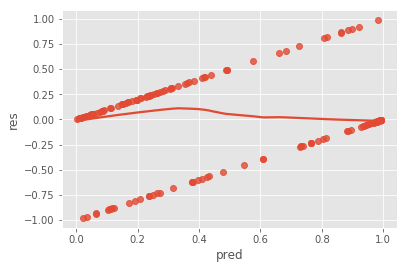

In [16]:
 ax = sns.regplot(x="pred", y="res", data=res_plot,lowess = True)

## Narysuj wykres kropkowy pokazujący zależność pomiędzy resztą (y - hat y) a wybraną zmienną zależną. Dodaj krzywą lokalnego trendu (np. loess lub gam) i sprawdź czy różni się od funkcji stale równej zero.



In [17]:
res_plot = pd.DataFrame(np.transpose(np.array([X_test.how_long_relationship,residuals])), columns=["how_long_relationship","res"])

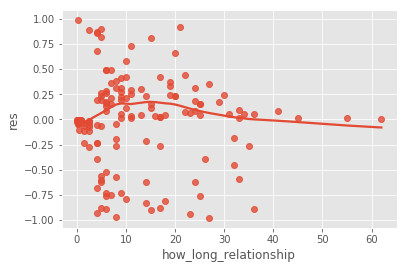

In [18]:
 ax = sns.regplot(x="how_long_relationship", y="res", data=res_plot,lowess = True)

Dla zmiennej how_long_relationship wykres układa się wokół prostej y=0 dla how_long_relatioship>25 (ale mamy tu mało obserwacji). Dla how_long_relatioship<25 wykres przypomina fragment paraboli z ujemnym współczynnikiem przy x^2, co sugeruje ze sensownym rozwiazaniem na poprawę modelu byłoby wprowadzonie transformacji zmiennej how_long_relationship.

## Dla każdej obserwacji policz wartości Cooka o ile zmieniłyby się predykcje modelu gdyby model uczyć na danych bez obserwacji i (miara wpływowości obserwacji i).

In [19]:
cook_distances = list()
for i in X_train.index:
    X_train2 = X_train.drop([i],axis=0)
    Y_train2 = Y_train.drop([i],axis=0)
    model2 = XGBClassifier(max_depth=10)
    model.fit(X_train2,Y_train2)
    cook_distances.append(sum([i*i for i in (model.predict_proba(X_test)[:,1]-predictions)]))
    

In [20]:
data_cook = pd.DataFrame(np.transpose([np.array(range(X_train.shape[0])),np.array(cook_distances)]),columns=["obs","cook_distance"])

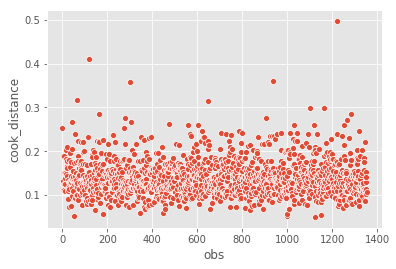

In [21]:
 ax = sns.scatterplot(x="obs", y="cook_distance", data=data_cook)

In [22]:
np.where(cook_distances==np.max(cook_distances)) 

(array([1220], dtype=int64),)

Dla obserwacji 1200 jest największa wartość odległości Cooka - jest to potencjalny outlier, jednak żeby to stwierdzić - powinniśmy przeprowadzić dalszą analizę.

In [23]:
X_train.iloc[1220,:]

age_difference           18.0
q26                       2.0
ppeducat                  3.0
q24_met_online            0.0
how_long_relationship    35.0
Name: 67, dtype: float64